In [17]:
%matplotlib inline
import twitter
import json
import pandas as pd
import numpy as np
import time
import subprocess
#import matplotlib.pyplot as plt

# Import unquote to prevent url encoding errors in next_results
# The urllib module is split into urllib.parse, urllib.request, 
# and urllib.error in Python 3
# If running this in Python 2, change urllib.parse to urllib
from urllib import unquote,urlencode


In [2]:
# OAuth login function for instantiating Twitter API object
def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    OAUTH_TOKEN = '250500792-'
    OAUTH_TOKEN_SECRET = ''

    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

In [3]:
# Find the up to 600 most recent tweets containing a given hashtag
# The returned object contains a massive amount of data
def find_tweets(hashtag):
    # Ensure that the hashtag argument is a string
    assert type(hashtag) == str, 'Argument hashtag must be a string'
    # Ensure that the hashtag argument is, indeed, a hashtag 
    # in quotes, i.e. a string beginning with a pound sign
    #assert hashtag[0] == '#', 'hashtag string must begin with a #'
    # Instantiate the Twitter API object 
    twitter_api = oauth_login()
    # Begin searching the Twitter API for tweets containing hashtag
    # Twitter only lets you find 100 tweets at a time 
    # (by default, the 100 most recent)
    search_results = twitter_api.search.tweets(q=hashtag, count=100, result_type='recent',
                                              #geocode = '37.7821120598956,-122.400612831116,1000mi')
                                                geocode = '39.8,-95.58306884,2500km');
    # Extract the information on the (up to) 100 most recent tweets
    # as a list
    statuses = search_results['statuses'] 
    # Iterate through 5 more batches of results by following the cursor 
    # back in time
    for _ in range(30):
        #print("Length of statuses", len(statuses))
        try:
            next_results = search_results['search_metadata']['next_results']
        # The as statement is required in Python 3  
        # A comma would be required instead for Python 2.5 and earlier  
        # Python 2.6 and 2.7 support both the comma and the as statement
        except KeyError as e: # No more results when next_results doesn't exist
            break
        
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([kv.split('=') for kv in unquote(next_results[1:]).split("&") ])    
        
        # Search for the 100 next most recent tweets
        search_results = twitter_api.search.tweets(**kwargs)
        # Append the results of the last search to the statuses list
        statuses += search_results['statuses']
        
    return statuses
    


In [4]:
# Resample/re-bin the time stamps to get a count of the tweets
# by time interval, which will vary by the the difference between
# the first and last time stamps
def resample_time_stamps(time_df, time_index):
    # Ensure that time_df is a DataFrame
    # The assert statement looks like this because 
    # we imported pandas as pd
    assert type(time_df) == pd.core.frame.DataFrame, 'Argument must be a pandas DataFrame'
    
    # Determine the range of times
    diff_year   = abs(time_index[0].year   - time_index[-1].year)
    diff_month  = abs(time_index[0].month  - time_index[-1].month)
    diff_day    = abs(time_index[0].day    - time_index[-1].day)
    diff_hour   = abs(time_index[0].hour   - time_index[-1].hour)
    diff_minute = abs(time_index[0].minute - time_index[-1].minute)
    diff_second = abs(time_index[0].second - time_index[-1].second)
    # Use the range of times to resample the data, 
    # and thus determine the plot format
    # Perhaps adjust this later
    if diff_year > 0:
        # Resample/bucket by month
        # The fillna(0) command fills any bins with NaN in them with 0s
        time_df = time_df.resample('M', how='sum').fillna(0)
        bin_width = 'month'
    elif diff_month > 0:
        if diff_month > 4:
            # Resample by week
            time_df = time_df.resample('W', how='sum').fillna(0)
            bin_width = 'week'
        else: 
            # Resample by day
            time_df = time_df.resample('D', how='sum').fillna(0)
            bin_width = 'day'
    elif diff_day > 0:
        if diff_day <= 10:
            # Resample by hour
            time_df = time_df.resample('H', how='sum').fillna(0)
            bin_width = 'hour'
        elif diff_day <= 21:
            # Resample by 6 hours
            time_df = time_df.resample('6H', how='sum').fillna(0)
            bin_width = '6 hours'
        else: 
            # Resample by day
            time_df = time_df.resample('D', how='sum').fillna(0)
            bin_width = 'day'
    elif diff_hour > 0:
        if diff_hour <= 3:
            # Resample by minute
            time_df = time_df.resample('T', how='sum').fillna(0)
            bin_width = 'minute'
        elif diff_hour <= 12:
            # Resample by 5 minutes
            time_df = time_df.resample('5T', how='sum').fillna(0)
            bin_width = '5 minutes'
        else: 
            # Resample by 10 minutes
            time_df = time_df.resample('10T', how='sum').fillna(0)
            bin_width = '10 minutes'
    elif diff_minute > 0:
        if diff_minute <= 3:
            # Resample by second
            time_df = time_df.resample('S', how='sum').fillna(0)
            bin_width = 'second'
        elif diff_minute <= 12:
            # Resample by 5 seconds
            time_df = time_df.resample('5S', how='sum').fillna(0)
            bin_width = '5 seconds'
        else: 
            # Resample by 10 seconds
            time_df = time_df.resample('10S', how='sum').fillna(0)
            bin_width = '10 seconds'
    elif abs(time_index[0].second - time_index[-1].second) > 0:
        # Resample/bucket (reorder) by second
        time_df = time_df.resample('S', how='sum').fillna(0)
        bin_width = 'second'
    else: 
        # Resample/bucket (reorder) by second
        time_df = time_df.resample('S', how='sum').fillna(0)
        bin_width = 'second'
    
    return time_df, bin_width

In [41]:
# Plot the time distribution of the (up to) 600 
# most recent tweets containing the desired hashtag
# Also returns a DataFrame containing the times 
# and locations (if available) of the tweets
def map_tweets(hashtag):
    # Ensure that the hashtag argument is a string
    #assert type(hashtag) == str, 'Argument hashtag must be a string'
    # Ensure that the hashtag argument is, indeed, a hashtag 
    # in quotes, i.e. a string beginning with a pound sign
    #assert hashtag[0] == '#', 'hashtag string must begin with a #'
    
    # Get all the data on the most recent tweets
    statuses = find_tweets(hashtag)
    print 'Found ',len(statuses),' tweets'
    # Initialize and populate a NumPy array with 
    # the time stamps of the tweets contained in 
    # statuses, in reverse chronological order
    time_stamps = np.array([])
#     for i in range(len(statuses)):
#         time_stamps = np.append(time_stamps, statuses[i]['created_at'])
    
    # Initialize and populate a NumPy array with 
    # the coordinates of the tweets contained in 
    # statuses, if available
    coordinates = np.array([])
     
    #     #print json.dumps(statuses[10], indent=1) 
    #     for i in range(len(statuses)):
    #         if 'coordinates' in statuses[i]['coordinates']: 
    #             coordinates = np.append(coordinates, statuses[i]['coordinates']) 
    #         else:

    #         #print json.dumps(statuses[i], indent=1) 
    
    locationInfo = [];
    
    for i in range(len(statuses)):
        if 'coordinates' in statuses[i]:
            if statuses[i]['coordinates'] is not None:
                coordinates = np.append(coordinates, statuses[i]['coordinates']) 
                time_stamps = np.append(time_stamps, statuses[i]['created_at'])
                element = {};
                element['type'] = 'Feature';
                element['properties'] ={'timestamp':statuses[i]['created_at']};#,'hashtag':hashtag};
                s = statuses[i]['coordinates'];
                element['geometry'] = s; 
                locationInfo.append(element);
                
            #print json.dumps(statuses[i]['coordinates'],indent=1)
            #             elif 'place' in statuses[i]:
            #                 if 'bounding_box' in statuses[i]['place']:
            #                     #print json.dumps(statuses[i]['place']['bounding_box'],indent=1)
            #                     coordinates = np.append(coordinates, statuses[i]['place']['bounding_box'])

   
    # Create an array of ones for every tweet
    ones_array = np.ones(len(time_stamps))
    # Create a Pandas DatetimeIndex of the time stamps
    time_index = pd.DatetimeIndex(time_stamps)
    # Create a Pandas DataFrame showing one tweet 
    # for each time stamp
    time_df = pd.DataFrame(ones_array, index=time_index, columns=['Tweets'])
    # Create a DataFrame associating a location with 
    # each time stamp, if available
    coord_df = pd.DataFrame(coordinates, index=time_index, columns=['Coordinates'])
    
    # Resample the DataFrame time_df
    time_df, bin_width = resample_time_stamps(time_df, time_index)
    
    
    
    
    # Create the plot
    time_plot = time_df.plot(legend=False)
    time_plot.set_xlabel('Date/Time')
    time_plot.set_ylabel('Tweets per '+ bin_width)
    time_plot.set_title('Frequency of tweets containing hashtag '+hashtag)
    
    
    #GeoJSON Formatting of the features 
    
    return time_plot, coord_df, locationInfo


Found  1070  tweets
found  1010  tweets about  #BlueMoon
1010
{"id":"b04b8096-9cd3-4c13-a651-1d8e86514237","user_id":"cb679e50-583c-45f9-840f-978bac88fc0a","table_id":null,"data_type":"url","table_name":null,"state":"uploading","error_code":null,"queue_id":"b04b8096-9cd3-4c13-a651-1d8e86514237","tables_created_count":null,"synchronization_id":null,"type_guessing":true,"quoted_fields_guessing":true,"content_guessing":false,"create_visualization":true,"visualization_id":null,"user_defined_limits":"{\"twitter_credits_limit\":0}","get_error_text":null,"display_name":"friday_oneSearch_merged_%23BlueMoon.geojson"}


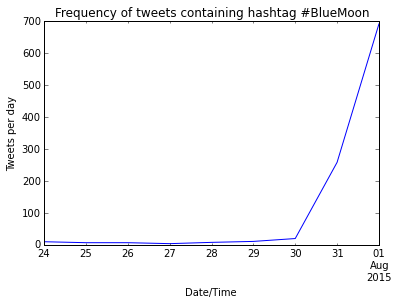

In [43]:
twobject = oauth_login();
allLocations = [];
#hashtags = ['\"Donald Trump\"', 'DonaldTrump','Trump2016',
#            '\"Hillary Clinton\"','Hillary2016','HillaryClinton'];


hashtags =['#BlueMoon'];

for hashtag in hashtags:
    timePlot, coordinates, lcInfo = map_tweets(hashtag); 
    allLocations += lcInfo;
    print 'found ',len(allLocations),' tweets about ',hashtag
    
lcInfo={};
lcInfo['type']="FeatureCollection";
lcInfo['features']=allLocations;

outputFile = 'friday_oneSearch_merged_'+hashtag+'.geojson';
print len(lcInfo['features'])
with open(outputFile, 'w') as outfile:
    json.dump(lcInfo, outfile)

command="curl -v -F file=@"+outputFile+" \"https://ilgeakkaya.cartodb.com/api/v1/imports/?api_key=&create_vis=true\"";


#TODO: Add table name

result = subprocess.check_output(command, shell=True)
resj = json.loads(result) 

if resj['success']:
    statusOfImport= "curl -v \"https://ilgeakkaya.cartodb.com/api/v1/imports/"+str(resj['item_queue_id'])+"?api_key=\"";
    res2 = subprocess.check_output(statusOfImport, shell=True)
    
print res2

In [46]:
iqi = '628f4a00-ebb2-4bd9-8659-78b3b0162617';
#iqi = '3d90474c-3811-11e5-bede-0e5e07bb5d8a';
if resj['success']:
    statusOfImport= "curl -v \"https://ilgeakkaya.cartodb.com/api/v1/imports/"+iqi+"?api_key=\"";
    res2 = subprocess.check_output(statusOfImport, shell=True)
    

{"id":"628f4a00-ebb2-4bd9-8659-78b3b0162617","user_id":"cb679e50-583c-45f9-840f-978bac88fc0a","table_id":"f8ca313f-5d68-4a85-b8b4-43db8b22fc3d","data_type":"url","table_name":"friday_onesearch_merged_23bluemoon_1","state":"complete","error_code":null,"queue_id":"628f4a00-ebb2-4bd9-8659-78b3b0162617","tables_created_count":1,"synchronization_id":null,"type_guessing":true,"quoted_fields_guessing":true,"content_guessing":false,"create_visualization":false,"visualization_id":null,"user_defined_limits":"{\"twitter_credits_limit\":0}","get_error_text":null,"display_name":"friday_oneSearch_merged_%23BlueMoon.geojson","success":true,"any_table_raster":false,"derived_visualization_id":null}


In [55]:

convertTimestamp = "curl -v \"https://ilgeakkaya.cartodb.com/api/v1/imports/q=SELECT *,timestamp::date timestamp2 FROM"+res2['table_name']+"&api_key=\"";
res3 = subprocess.check_output(statusOfImport, shell=True)

print json.dumps(json.loads(res3), indent=1)

{
 "quoted_fields_guessing": true, 
 "derived_visualization_id": null, 
 "user_id": "cb679e50-583c-45f9-840f-978bac88fc0a", 
 "create_visualization": false, 
 "data_type": "url", 
 "any_table_raster": false, 
 "visualization_id": null, 
 "type_guessing": true, 
 "get_error_text": null, 
 "success": true, 
 "synchronization_id": null, 
 "display_name": "friday_oneSearch_merged_%23BlueMoon.geojson", 
 "user_defined_limits": "{\"twitter_credits_limit\":0}", 
 "state": "complete", 
 "table_id": "f8ca313f-5d68-4a85-b8b4-43db8b22fc3d", 
 "tables_created_count": 1, 
 "queue_id": "628f4a00-ebb2-4bd9-8659-78b3b0162617", 
 "table_name": "friday_onesearch_merged_23bluemoon_1", 
 "error_code": null, 
 "id": "628f4a00-ebb2-4bd9-8659-78b3b0162617", 
 "content_guessing": false
}


In [50]:
print res2['table_name']

friday_onesearch_merged_23bluemoon_1


In [7]:

c = pycurl.Curl() 
c.setopt(c.POST, 1)
c.setopt(c.USERAGENT, 'Curl')
c.setopt(c.VERBOSE, 1) 
ACCESS_TOKEN=""
c.setopt(c.HTTPHEADER, [
    'auth_token: %s' % str(ACCESS_TOKEN),
    'Content-Type: multipart/related',
])
filepath="/Users/oldilge/Google Drive/twitter-trends/"+outputFile;
c.setopt(c.URL,"https://ilgeakkaya.cartodb.com/api/v1/imports/")

data = [ 
    ('file', (
        c.FORM_FILE, outputFile, 
        c.FORM_CONTENTTYPE, 'application/geojson')) 
]

post_data = {'auth_token':str(ACCESS_TOKEN),
            'table_name':outputFile};
postfields = urlencode(post_data)
c.setopt(c.POSTFIELDS,postfields)
c.setopt(c.HTTPPOST, data)
c.setopt(c.SSL_VERIFYPEER, 0) 
c.perform()

# HTTP response code, e.g. 200.
print('Status: %d' % c.getinfo(c.RESPONSE_CODE))
# Elapsed time for the transfer.
print('Status: %f' % c.getinfo(c.TOTAL_TIME))
c.close()



Status: 401
Status: 1.522703


In [170]:
#Moving on to CartoDB
from cartodb import CartoDBAPIKey, CartoDBException

API_KEY="" #redacted
cartodb_domain = 'ilgeakkaya'
cl = CartoDBAPIKey(API_KEY, cartodb_domain)
 
    
fi = FileImport(filepath, cl)
fi.run()



NameError: name 'FileImport' is not defined

In [1]:
for  i in range(3):
    print i
    

0
1
2
